This notebook contains the code of the most similar atlas (SIM) approach 

In [2]:
# Import libraries
from pathlib import Path
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pickle
import numpy as np 
import os
from tqdm import tqdm

from metadata import ImageDataset, patient

In [3]:
notebook_path = Path().cwd()
repo_path = notebook_path.parent
print(f'The current directory is: {notebook_path}')

The current directory is: d:\VS_Projects\MISA_FINAL_PROJECT\notebooks


In [39]:
#instantiate dataset, specify set name
img_training_data = ImageDataset('Training')
im_val_data = ImageDataset('Validation')

#check length
# print(f'len: {img_training_data.len}')
# #get all ids (useful to iterate over all adataset)
# print(f'all ids: {img_training_data.IDs}')
# #get list of all images paths for training
print(f'images paths: {img_training_data.im_paths()}')
# #same for the labels
# print(f'images paths: {img_training_data.labels_paths()}')


#select one id of patient to check
id = img_training_data.IDs[0]
id_val = im_val_data.IDs[0]
print(f'selected id: {id}')
#istantiate patient object using the id and the previous ImageDataset object
pat = patient(id, img_training_data)
pat_val = patient(id_val, im_val_data)

# pat.show('labels')
# pat.show('im')

# Get the image and the labels
im = pat.im()
labels = pat.labels()

im_val = pat_val.im()
labels_val = pat_val.labels()

images paths: ['data\\Training_Set\\IBSR_01\\IBSR_01.nii.gz', 'data\\Training_Set\\IBSR_03\\IBSR_03.nii.gz', 'data\\Training_Set\\IBSR_04\\IBSR_04.nii.gz', 'data\\Training_Set\\IBSR_05\\IBSR_05.nii.gz', 'data\\Training_Set\\IBSR_06\\IBSR_06.nii.gz', 'data\\Training_Set\\IBSR_07\\IBSR_07.nii.gz', 'data\\Training_Set\\IBSR_08\\IBSR_08.nii.gz', 'data\\Training_Set\\IBSR_09\\IBSR_09.nii.gz', 'data\\Training_Set\\IBSR_16\\IBSR_16.nii.gz', 'data\\Training_Set\\IBSR_18\\IBSR_18.nii.gz']
selected id: 01


In [5]:
def image_registration(fixedImage, movingImage):
    """Give two images and the registration of both, and its transformation map will be given

    Args:
        fixed_path (str): fixed (template) image
        moving_path (str): moving image (image that will be transformed)

    Returns:
        sitk image, transformix map: transformed image and the transformation map
    """

    #Start registration settings
    elastixImageFilter = sitk.ElastixImageFilter() #Image filter object
    #Defining settings
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)

    #Run registration
    elastixImageFilter.Execute()

    #Get result image
    resultImage = elastixImageFilter.GetResultImage()

    #Transformation map
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    transformParameterMap[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformParameterMap[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]    
    transformParameterMap[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    return resultImage, transformParameterMap

### Registration and label propagation

In [6]:
if not os.path.exists(repo_path / "data" / "registered_labels_all"):
    os.makedirs(repo_path / "data" / "registered_labels_all")

In [7]:
# for each training image, register it to the validation image
def save_registered_labels():

    path_to_save_labels = repo_path / "data" / "registered_labels_all"

    list_labels_all = []
    for i in tqdm(range(len(img_training_data.IDs))):
        id = img_training_data.IDs[i]
        pat = patient(id, img_training_data)
        moving_image = pat.im(preprocess=True)
        labels = pat.labels()

        list_labels = []
        for v in range(len(im_val_data.IDs)):

            id_val = im_val_data.IDs[v]

            print(f'Registering training image {id} to validation image {id_val}...')

            pat_val = patient(id_val, im_val_data)
            fixed_image = pat_val.im(preprocess=True)
            labels_val = pat_val.labels()

            resultImage, transformParameterMap = image_registration(fixed_image, moving_image) #Resgiter images using predefined transform map

            transformixImageFilter = sitk.TransformixImageFilter() #Create object transform matrix
            transformixImageFilter.SetTransformParameterMap(transformParameterMap) #Set with found transform
            transformixImageFilter.SetMovingImage(labels) #set labels as moving
            transformixImageFilter.Execute() #Tranform labels

            labels_registered = transformixImageFilter.GetResultImage() #Propagated labels

            with open(path_to_save_labels / f'trans_labels_{id}_to_{id_val}.p', 'wb') as handle:   #Save propagated labels as pickle file
                pickle.dump(labels_registered, handle, pickle.HIGHEST_PROTOCOL)

In [28]:
# read the pickle files

path_to_save_labels = repo_path / "data" / "registered_labels_all"


for v in range(len(im_val_data.IDs)):
    list_per_each_val=[]
    id_val = im_val_data.IDs[v]
    
    for i in tqdm(range(len(img_training_data.IDs))):
        id = img_training_data.IDs[i]
        
        with open(path_to_save_labels / f'trans_labels_{id}_to_{id_val}.p', 'rb') as handle:   #Load all propagated labels
            list_labels= pickle.load(handle)
            list_per_each_val.append(list_labels)
            #to save all the propagated labels in one file per each validation image. (in total 5 different files)
    with open(repo_path / "data" / f'all_trans_labels_{id_val}.p', 'wb') as handle: 
        pickle.dump(list_per_each_val, handle, pickle.HIGHEST_PROTOCOL)


100%|██████████| 10/10 [00:00<00:00, 23.45it/s]


### Make probablistic Atlas from propagated labels 

In [108]:
with open(repo_path / "data" / f'all_trans_labels_12.p', 'rb') as handle:   #Load all propagated labels
    list_labels= pickle.load(handle)

In [109]:
atlas = np.zeros(shape=(3,) + sitk.GetArrayFromImage(list_labels[0]).shape,dtype=np.float32) #Array to store

for k in range(1,4): #Go for each tissue    
    for label in list_labels: # Go through all images
        label = sitk.GetArrayFromImage(label) 
        atlas[k-1] = atlas[k-1] + (label==k)   #Accumulated atlas
    atlas[k-1] = atlas[k-1]/len(list_labels) #Finally get mean

In [110]:
print(np.unique(atlas))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


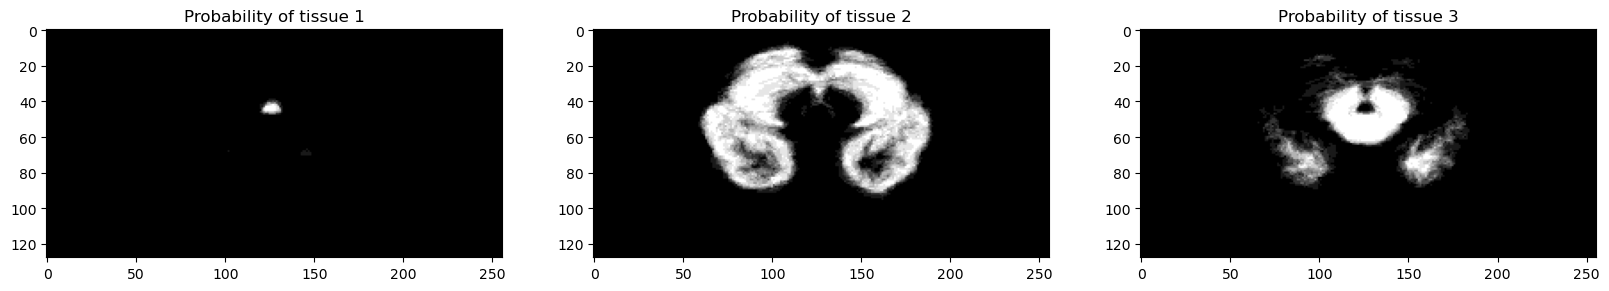

In [111]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,20))
for k in range(1,4):
    axs[k-1].imshow(atlas[k-1][100], cmap='gray')
    axs[k-1].set_title(f'Probability of tissue {k}')

In [76]:
# save atlasses
# save the array as a new nifti image
def save_as_nifti(array, filename, reference_image):
    """Save array as nifti image

    Args:
        array (array): array to be saved
        filename (str): path to save
        reference_image (str): path of reference image
    """
    reference_image = sitk.ReadImage(reference_image)
    image = sitk.GetImageFromArray(array)
    image.SetOrigin(reference_image.GetOrigin())
    image.SetSpacing(reference_image.GetSpacing())
    image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, filename)

for v in range(len(im_val_data.IDs)):
    list_per_each_val=[]
    id_val = im_val_data.IDs[v]
    paths= im_val_data.im_paths()

    fixed_path = repo_path / paths[v]
    fixed_path = str(fixed_path)
    csf_atlas = atlas[0] #Save CSF volume
    wm_atlas = atlas[1] #Save WM volume
    gm_atlas = atlas[2] #Save GM volume
    save_as_nifti(csf_atlas, str(repo_path) + f'\\data\\atlas_results\csf_atlas_{id_val}.nii', fixed_path)
    save_as_nifti(wm_atlas, str(repo_path) + f'\data\\atlas_results\wm_atlas_{id_val}.nii', fixed_path)
    save_as_nifti(gm_atlas, str(repo_path) + f'\data\\atlas_results\gm_atlas_{id_val}.nii', fixed_path)

## Segmentation using Atlas 

In [112]:
def getArrayfromPath(image_path, dtype = np.uint16):
    """Simply get array of image

    Args:
        image_path (str): image path

    Returns:
        array: array of the image
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(image_path)).astype(dtype)

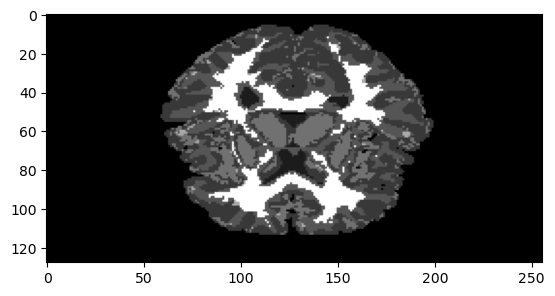

In [113]:
#propagate labels for each tissue type

id_val = 11
paths= im_val_data.im_paths()

fixed_path = repo_path / paths[0]
fixed_path = str(fixed_path)
fixed_shape = getArrayfromPath(fixed_path).shape

prop_labels = np.zeros(shape=(3,)+ fixed_shape)
for i, tissue in enumerate(['csf', 'wm', 'gm']):
    prop_labels[i] = getArrayfromPath(str(repo_path) + f'\data\\atlas_results\{tissue}_atlas_{id_val}.nii')

#Get segmentation from propagated labels
im_seg = np.argmax(prop_labels, axis=0) + 1 #max argument and adding one
paths= im_val_data.labels_paths()
mask_path = str(repo_path / paths[0]) # get the path of the validation image 11's mask
mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)).astype(np.uint16)
im_seg = im_seg * mask #apply mask to segmentation
plt.imshow(im_seg[135,:,:], cmap='gray')

In [107]:
# check how many different values in the segmentation
np.unique(im_seg)

array([0, 1, 2, 3, 4, 6, 9], dtype=int64)